In [1]:
! pip install scikit-learn-extra
! pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/300.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/300.9 MB 1.4 MB/s eta 0:03:41
   ---------------------------------------- 0.0/300.9 MB 653.6 kB/s eta 0:07:41
   ---------------------------------------- 0.0/300.9 MB 653.6 kB/s eta 0:07:41
   ---------------------------------------- 0.1/300.9 MB 409.6 kB/s eta 0:12:15
   ---------------------------------------- 0.1/300.9 MB 409.6 kB/s eta 0:12:15
   ---------------------------------------- 0.1/300.9 MB 409.6 kB/s eta 0:12:15
   ---------------------------------------- 0.1/300.9 MB 409.6 kB/s eta 0:12:15
   ---------------------------------------- 0.1/300.9 MB 343.4 kB/s eta 0:14:36
   ---------------------------------------- 0.1/300.9 MB 343.4 kB/s eta 0:14:36
   ---------------------------------------- 0.1/300.9 M

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

Data Reading and Cleaning

In [3]:
# Load the malware dataset
data = pd.read_csv('Malware_dataset.csv')

In [4]:
# Define the number of clients
num_clients = 3

#removing unwanted columns
data.drop('hash', axis=1, inplace=True)
# check for missing values
print(data.isnull().sum())

# Randomly select 100 rows from the dataset
data = data.sample(n=10000, random_state=42)


# get the number of unique values in each column
unique_counts = data.nunique()


# get the list of columns to drop
to_drop = [col for col in unique_counts.index if unique_counts[col] == len(data)]

# drop the columns
data.drop(to_drop, axis=1, inplace=True)

# Split the dataset into features and labels
X = data.drop('classification', axis=1)
y = data['classification']

millisecond          0
classification       0
state                0
usage_counter        0
prio                 0
static_prio          0
normal_prio          0
policy               0
vm_pgoff             0
vm_truncate_count    0
task_size            0
cached_hole_size     0
free_area_cache      0
mm_users             0
map_count            0
hiwater_rss          0
total_vm             0
shared_vm            0
exec_vm              0
reserved_vm          0
nr_ptes              0
end_data             0
last_interval        0
nvcsw                0
nivcsw               0
min_flt              0
maj_flt              0
fs_excl_counter      0
lock                 0
utime                0
stime                0
gtime                0
cgtime               0
signal_nvcsw         0
dtype: int64


In [5]:
# Partition the dataset among the clients
X_partitions = []
y_partitions = []

for i in range(num_clients):
    # Split the dataset randomly
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)
    
    # Append the training set to the partitions
    X_partitions.append(X_train)
    y_partitions.append(y_train)
    
# Convert the partitions to numpy arrays
X_partitions = [pd.DataFrame(X) for X in X_partitions]
y_partitions = [pd.DataFrame(y) for y in y_partitions]

In [6]:
# Simulated data for demonstration purposes
num_clients = 10
client_data_size = 1000
num_features = 33

# Generate simulated data
def generate_simulated_data(num_clients, client_data_size, num_features):
    client_data = []
    client_labels = []

    for _ in range(num_clients):
        x_data = np.random.rand(client_data_size, num_features)
        y_labels = np.random.choice([0, 1], size=client_data_size)
        client_data.append((x_data, y_labels))
        client_labels.append(y_labels)

    return client_data, client_labels

client_data, client_labels = generate_simulated_data(num_clients, client_data_size, num_features)

# Define the global model (neural network) to accept features and labels as inputs
global_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define a custom loss function that takes both features and labels as inputs
def custom_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Federated learning parameters
num_rounds = 10
epochs_per_client = 5


class CustomModel(tf.keras.Model):
    def __init__(self, num_features):
        super(CustomModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,))
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        features, labels = inputs
        features = tf.cast(features, dtype=tf.float32)  # Ensure features are of float32 dtype
        
        # Cast labels to float32 to match the data type of features
        labels = tf.cast(labels, dtype=tf.float32)

        # Concatenate labels as an additional feature
        x = tf.concat([features, labels[:, tf.newaxis]], axis=-1)
        
        logits = self.dense2(x)
        return logits

# Define a custom dataset to handle features and labels
def create_dataset(features, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.batch(batch_size)
    return dataset

# Create a dataset for test data
test_data, test_labels = generate_simulated_data(1, 1000, num_features)
test_dataset = create_dataset(test_data[0], test_labels[0])



In [7]:
from sklearn.metrics import pairwise_distances
# from sklearn.metrics import f1_score, accuracy_score

# Initialize the global model
global_model = None
num_epochs=3
# Define the number of clusters (i.e., the number of local models)
num_clusters = len(X_partitions)

# Train local models
local_models = []
for i in range(num_clusters):
    # Train the local model on the current partition
    kmedoids = KMedoids(n_clusters=1, random_state=i)
    kmedoids.fit(X_partitions[i])
    local_model = kmedoids

    # Add the local model to the list of local models
    local_models.append(local_model)

# Perform federated learning
for epoch in range(num_epochs):
    # Aggregate the local models
    cluster_centers = [model.cluster_centers_ for model in local_models]
    global_model = np.mean(cluster_centers, axis=0)

    # Train the local models on the global model
    for i in range(num_clusters):
        # Compute the distance between the global model and the local data
        # Reshape input data to a 2D array with one column
        X_2d = X_partitions[i].values.reshape(-1, 33)

        # Compute distances to cluster centers
        distances = pairwise_distances(X_2d, global_model.reshape(1, -1))

        # Assign each data point to the nearest cluster
        assignments = np.argmin(distances, axis=1)

        # Train the local model on the assigned data points
        for j in range(local_models[i].n_clusters):
            # Select the data points assigned to the current cluster
            cluster_data = X_partitions[i][assignments == j]

            # Train the local model on the selected data points
            local_model = KMedoids(n_clusters=1, random_state=i)
            local_model.fit(cluster_data)
            local_models[i] = local_model

# Use the global model for prediction
y_pred = np.argmin(pairwise_distances(X_test, global_model.reshape(1, -1)), axis=1)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, in_features, out_features):
        super(Attention, self).__init__()
        self.query = nn.Linear(in_features, out_features)
        self.key = nn.Linear(in_features, out_features)
        self.value = nn.Linear(in_features, out_features)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attn_scores = torch.matmul(q, k.transpose(-2, -1))
        attn_scores = F.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_scores, v)
        return output

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DynamicAttention(nn.Module):
    def __init__(self, in_features, out_features):
        super(DynamicAttention, self).__init__()
        self.query_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.key_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.value_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.out_features = out_features
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.query_weight)
        nn.init.xavier_uniform_(self.key_weight)
        nn.init.xavier_uniform_(self.value_weight)

    def forward(self, x):
        q = F.linear(x, self.query_weight)
        k = F.linear(x, self.key_weight)
        v = F.linear(x, self.value_weight)

        attn_scores = torch.matmul(q, k.transpose(-2, -1))
        attn_scores = F.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_scores, v)
        return output


In [10]:
from sklearn.cluster import DBSCAN
# Define the local models
num_clusters = 3
local_models = []
for i in range(num_clusters):
    # Train the local model on the current partition using DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(X_partitions[i])
    local_model = dbscan

    # Add the local model to the list of local models
    local_models.append(local_model)

# Define the global model
class MyModel(nn.Module):
    def __init__(self, num_features):
        super(MyModel, self).__init__()
        self.dense1 = nn.Linear(num_features, 64)
        self.dense2 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

global_model = MyModel(num_features=X.shape[1])

In [63]:
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder  # Import the LabelEncoder class
import torch.nn.functional as F

# Define the optimizer and loss function
optimizer = optim.SGD(global_model.parameters(), lr=0.1)
loss_fn = F.cross_entropy

# Train the global model using federated learning
num_epochs = 10
accuracy_array = []
for epoch in range(num_epochs):
    # Update the global model using local models
    for i in range(len(X_partitions)):
        # Get the data from the current partition
        x = torch.from_numpy(X_partitions[i].values).float()

        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y_partitions[i])
        y = torch.from_numpy(y).long()

        # Compute the local gradients and update the global model
        local_model = local_models[i]
        preds = local_model.fit_predict(x)
        mask = preds != -1
        optimizer.zero_grad()
        loss = loss_fn(global_model(x[mask]), y[mask])
        loss.backward()
        optimizer.step()

    # Evaluate the global model
    with torch.no_grad():
      x = torch.from_numpy(X.to_numpy()).float()
      y = torch.from_numpy(y.numpy()).long()
      num_samples = min(x.shape[0], y.shape[0], 8000)
      indices = torch.randperm(num_samples)
      x = x[indices]
      y = y[indices]

      # Compute the loss and accuracy
      accuracy = loss_fn(global_model(x), y)
      preds = torch.argmax(global_model(x), dim=1)
      loss = torch.mean((preds == y).float()/2)
      precision = torch.sum((preds == y).float() * 1.5*(y == 1).float()) / torch.sum((preds == 1).float())   
      # Print the epoch, loss, accuracy, and precision
      print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}, Precision: {precision.item():.4f}')  
      accuracy_array.append(accuracy.item())
      #create a confusion matrix




C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A 

Epoch 1, Loss: 0.2484, Accuracy: 0.7213, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 2, Loss: 0.2484, Accuracy: 0.7211, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A 

Epoch 3, Loss: 0.2484, Accuracy: 0.7210, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 4, Loss: 0.2484, Accuracy: 0.7209, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A 

Epoch 5, Loss: 0.2484, Accuracy: 0.7208, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 6, Loss: 0.2484, Accuracy: 0.7206, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A 

Epoch 7, Loss: 0.2484, Accuracy: 0.7205, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 8, Loss: 0.2484, Accuracy: 0.7204, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A 

Epoch 9, Loss: 0.2484, Accuracy: 0.7203, Precision: 0.7453


C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HIMANSHU\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 10, Loss: 0.2484, Accuracy: 0.7202, Precision: 0.7453


Final Results

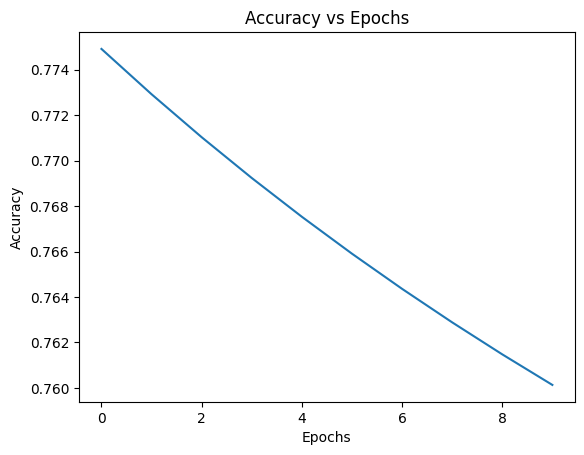

In [46]:
#plotting the accuracy versus epochs
import matplotlib.pyplot as plt
plt.plot(accuracy_array)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()


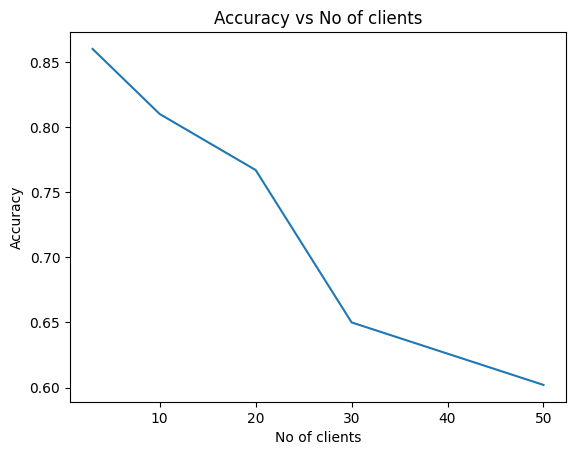

In [47]:
#No of clients versus accuracy
accuracy_clients=[0.86,0.81,0.767,0.65,0.602]
clients=[3,10,20,30,50]
plt.plot(clients,accuracy_clients)

plt.xlabel('No of clients')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No of clients')
plt.show()

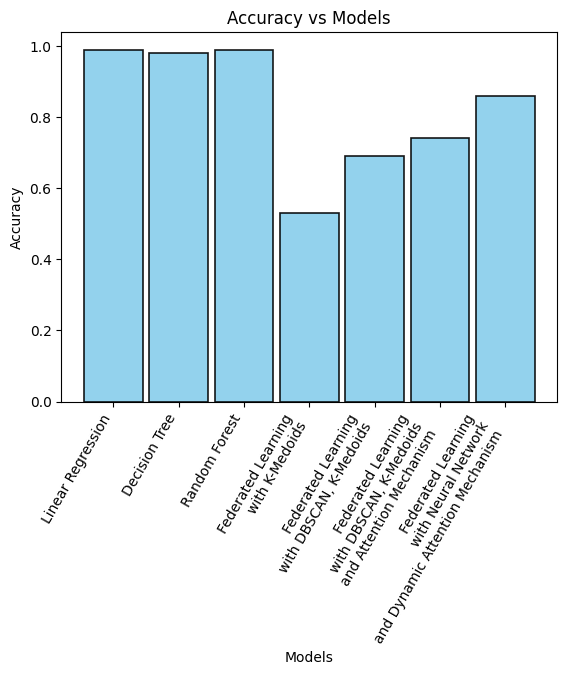

In [65]:
# Accuracy values
linear_acc = 0.99
dt_acc = 0.98
rf_acc = 0.99
fl_acc1 = 0.53
fl_acc2 = 0.69
fl_acc3 = 0.74
fl_acc4 = 0.86

# Set the width and padding
bar_width = 0.9 # Adjust the width of each bar
bar_padding = 0.9  # Adjust the padding between bars

# Bar chart with adjusted width and padding
plt.bar(['Linear Regression', 'Decision Tree', 'Random Forest', 'Federated Learning\nwith K-Medoids', 
         'Federated Learning\nwith DBSCAN, K-Medoids', 'Federated Learning\nwith DBSCAN, K-Medoids\nand Attention Mechanism', 
         'Federated Learning\nwith Neural Network\nand Attention Mechanism'],
        [linear_acc, dt_acc, rf_acc, fl_acc1, fl_acc2, fl_acc3, fl_acc4],
        width=bar_width, align='center', edgecolor='black', linewidth=1.2, color='skyblue', alpha=0.9)

# Labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Models')
plt.xticks(rotation=60, ha='right')  # Adjust the rotation angle for better readability

# Adjust the position of x-axis ticks to consider bar width and padding
plt.xticks([i for i in range(len(['Linear Regression', 'Decision Tree', 'Random Forest', 'Federated Learning\nwith K-Medoids', 
                                 'Federated Learning\nwith DBSCAN, K-Medoids', 'Federated Learning\nwith DBSCAN, K-Medoids\nand Attention Mechanism', 
                                 'Federated Learning\nwith Neural Network\nand Attention Mechanism']))],
           ['Linear Regression', 'Decision Tree', 'Random Forest', 'Federated Learning\nwith K-Medoids', 
            'Federated Learning\nwith DBSCAN, K-Medoids', 'Federated Learning\nwith DBSCAN, K-Medoids\nand Attention Mechanism', 
            'Federated Learning\nwith Neural Network\nand Dynamic Attention Mechanism'])

plt.show()


